In [1]:
# %load ../scripts/f_common_script.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import re
import scienceplots
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

# Section:Global variables
my_seed = 42
np.random.seed(my_seed)


# Section:Functions for plotting
def add_trendline(x, y, ax):
    # Sort x and y values to ensure a continuous line
    # convert x and y to numpy array
    x = np.array(x)
    y = np.array(y)
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]

    # Fit polynomial and create trendline
    z = np.polyfit(x_sorted, y_sorted, 2)
    p = np.poly1d(z)
    ax.plot(x_sorted, p(x_sorted), "--", color='red', linewidth=2)


def plot_actual_vs_predicted(y_test, y_pred, fig_name='../figs/actual_vs_predicted.pdf', xlabel='Actual', ylabel='Estimated', trendline=True) -> None:
    # plot the actual vs predicted, with a line of y=x
    plt.style.use(['science'])
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [
        y_test.min(), y_test.max()], 'k-', lw=2)
    if trendline:
        add_trendline(y_test, y_pred, ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # ax.set_title('Actual vs Predicted')
    plt.savefig(fig_name, format='pdf')
    plt.show()

# check the 'normalized_total_pv_gen_correct' during date 2022-07-01 to 2022-07-31


def df_common_xylabel_plot(df, y, doy_start=0, doy_end=366, year=[2017, 2018, 2019], xlabel='Datetime', ylabel="example ylabel", layout=(7, 4), subplots=True, figsize=(20, 20)):
    # make a list to plot, excluding the columns of datetime and Timestamp
    axes = df[(df['doy'] >= doy_start) & (df['doy'] <= doy_end) & (df['year'].isin(year))].plot(
        x='datetime', y=y, subplots=subplots, figsize=figsize, layout=layout, sharex=True, xlabel='')
    if subplots == True:
        fig = axes[0, 0].get_figure()
    else:
        fig = axes.get_figure()  # to avoid the problem of "'Axes' object is not subscriptable"
    # add a common y label
    fig.text(0.08, 0.5, ylabel, va='center', rotation='vertical', size=20)
    # add a common x label
    fig.text(0.5, 0.0, xlabel, ha='center', size=20)


In [2]:
def calc_percentage_error(real_capacities,estimated_capacities):
    if np.isnan(real_capacities).any() or np.isnan(estimated_capacities).any():
        return np.nan
    # If there is NaN in estimate_capacities, set the corresponding real_capacities to NaN
    # real_capacities[np.isnan(estimated_capacities)] = np.nan
    return (real_capacities.sum() - estimated_capacities.sum()) / real_capacities.sum() * 100
def calc_mean_percentage_error(real_capacities,estimated_capacities):
    if np.isnan(real_capacities).any() or np.isnan(estimated_capacities).any():
        return np.nan
    # n is the length of real_capacities
    n=real_capacities.size
    # individual_errors is the percentage error of each household
    individual_errors = (real_capacities - estimated_capacities)/real_capacities # Avoid division by zero
    # shape of individual_errors  
    return individual_errors.sum()/n*100
def calc_error_factor(real_capacities_sum,estimated_capacities_sum):
    return real_capacities_sum/estimated_capacities_sum

def calc_r2_score(real_capacities,estimated_capacities):
    # if there is any NaN in real_capacities or estimated_capacities, return NaN
    if np.isnan(real_capacities).any() or np.isnan(estimated_capacities).any():
        return np.nan
    return r2_score(real_capacities,estimated_capacities)


# Load data

In [3]:
# # load the ready-to-use data
# f_name = '../data/nl/ams_data_ready_to_use.csv'
f_name='../data/nl/ams_data_merged_preprocessed.csv'
f_name_pv_capacity = '../data/nl/ams_pv_capacity_from_pv_profiles.csv'
df = pd.read_csv(f_name)
df_pv_capacity = pd.read_csv(f_name_pv_capacity)

In [4]:
# split the df_pv_capacity into part 1 and part 2, the first 10 household are part 1, the rest are part 2
df_pv_capacity_part1=df_pv_capacity.drop(df_pv_capacity.index[10:])
df_pv_capacity_part2=df_pv_capacity.drop(df_pv_capacity.index[:10])

In [5]:
df_pv_capacity_part1.shape

(10, 2)

In [6]:
f_name1='../data/nl/ams_data_merged_preprocessed_part1.csv'
df_part1=pd.read_csv(f_name1)
f_name2='../data/nl/ams_data_merged_preprocessed_part2.csv'
df_part2=pd.read_csv(f_name2)

In [7]:
df_pv_capacity

,Unnamed: 0,0
0,1011W,2963.038537
1,1954W,2819.092155
2,1955A,2825.082006
3,1964J,2770.849033
4,2053G,3409.944232
5,2442E,1446.058540
6,3070L,2465.613342
7,3517V,879.807524
8,3660D,2857.514911
9,3726A,3065.970353


In [8]:
# rename the first column of df_pv_capacity to 'household', second to 'capacity'
df_pv_capacity.rename(columns={df_pv_capacity.columns[0]: 'household', df_pv_capacity.columns[1]: 'capacity'}, inplace=True)
df_pv_capacity


,household,capacity
0,1011W,2963.038537
1,1954W,2819.092155
2,1955A,2825.082006
3,1964J,2770.849033
4,2053G,3409.944232
5,2442E,1446.058540
6,3070L,2465.613342
7,3517V,879.807524
8,3660D,2857.514911
9,3726A,3065.970353


In [9]:
df_pv_capacity_part1.rename(columns={df_pv_capacity_part1.columns[0]: 'household', df_pv_capacity_part1.columns[1]: 'capacity'}, inplace=True)
df_pv_capacity_part2.rename(columns={df_pv_capacity_part2.columns[0]: 'household', df_pv_capacity_part2.columns[1]: 'capacity'}, inplace=True)
df_pv_capacity_part1
df_pv_capacity_part2

,household,capacity
10,3932W,981.130065
11,4451M,5192.548449
12,5427W,1374.035231
13,5815T,2848.621677
14,7426U,934.936854
15,7679U,2871.897837
16,7710F,1574.498716
17,8319Q,2803.467388
18,9248C,965.216083
19,9370J,2554.771613


In [10]:
# drop the columns of 9506H, because there is no solar panels.
# drop the columns of 4226R, because there is weird data in 2019 March.
# drop the column of 7743P, for the high missing rate of 0.948231.
# drop the column of 7099P because none of its data is in summer.
# drop the columns of 3308S and 2108P, because they seem to have some demand response strategies.
households_to_remove = ['9506H', '4226R', '7743P', '7099P', '3307S', '2108P']
df_pv_capacity = df_pv_capacity[~df_pv_capacity['household'].isin(households_to_remove)]

In [11]:
df_pv_capacity

,household,capacity
0,1011W,2963.038537
1,1954W,2819.092155
2,1955A,2825.082006
3,1964J,2770.849033
4,2053G,3409.944232
5,2442E,1446.058540
6,3070L,2465.613342
7,3517V,879.807524
8,3660D,2857.514911
9,3726A,3065.970353


In [12]:
# columns that ends with '_pv'
pv_cols = [col for col in df.columns if col.endswith('_pv')]
# columns that ends with '_con'
con_cols = [col for col in df.columns if col.endswith('_con')]
# columns that ends with '_net'
net_cols = [col for col in df.columns if col.endswith('_net')]

# Check the distribution of irradiance

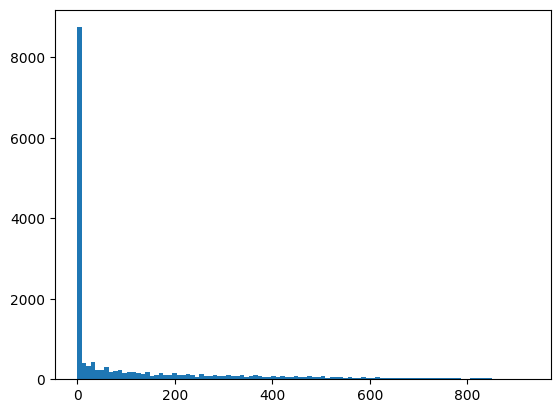

In [13]:
# histogram of irradiance
plt.hist(df['irradiance'], bins=100)
plt.show()

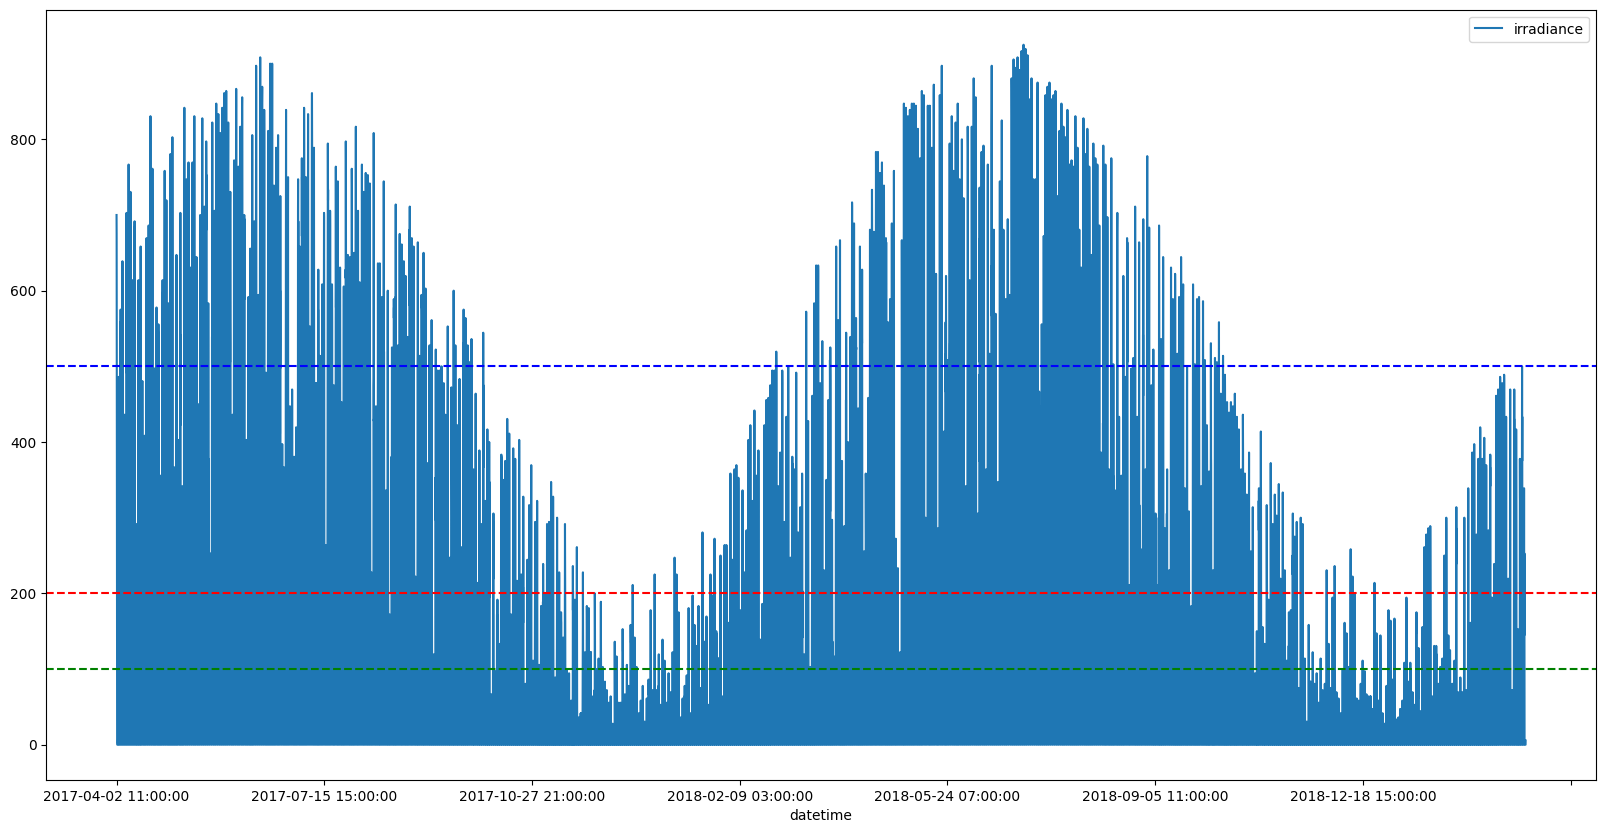

In [14]:
df_part1.plot(x='datetime',y='irradiance',figsize=(20,10))
# draw a line where y=200
plt.axhline(y=200, color='red', linestyle='--')
# draw a line where y=500
plt.axhline(y=500, color='blue', linestyle='--')
# draw a line where y=1000
plt.axhline(y=100, color='green', linestyle='--')
plt.show()

# Capacity estimation based on base load

In [15]:
class capacity_estimation_based_load:
    """
    A class for estimating the capacity of PV systems.
    Step 1: Sample the net load at night time as base load, when irradiance is low and PV gen is zero.
    Step 2: Sample the load around the characteristic dip as noon load, where PV generation is the highest.
    Step 3: Calculate the capacity, which is (base load - noon load) * correction factor,
    where the correction factor is (max_irradiance/sample_irradiance).
    """
    def __init__(self, df: pd.DataFrame, cols: list, irradiance_threshold_noon: float=500, irradiance_threshold_night: float =0.01, max_irradiance: float =1000,base_load_correction_factor =None):
        self.df = df
        self.cols = cols
        self.irradiance_threshold_noon = irradiance_threshold_noon
        self.irradiance_threshold_night= irradiance_threshold_night
        self.max_irradiance = max_irradiance
        self.base_load_correction_factor = base_load_correction_factor
        # why higher threshold_noon?
        # because the when PV gen is dominating, the error is smaller.
        # the minimal irradiance for PV to generate power is 
        self.base_load = None
        self.correction_factors = None
    def estimate_capacity(self) -> pd.Series:
        self.base_load_estimation()
        self.noon_load_estimation()
        # first use base_load - peak_load, then use the correction factor
        pv_gen_not_corrected = self.base_load - self.high_irradiance_df[self.cols] 
        pv_gen_corrected = pv_gen_not_corrected.multiply(self.correction_factors, axis=0)
        pv_gen_capacity= pv_gen_corrected.mean()
        return pv_gen_capacity
    def base_load_estimation(self):
        # use the net load at night time as the base load
        # when irradiance is below threshold, the net load is the base load
        self.base_load_at_night = self.df[self.df['irradiance'] < self.irradiance_threshold_night][self.cols].mean()
        # calculate the correction factor based on total_con(at daylight)/total_con(at night)
        if self.base_load_correction_factor is None:
            self.base_load_correction_factor = self.df[self.df['irradiance'] > self.irradiance_threshold_noon]['total_con'].mean() / self.df[self.df['irradiance'] <= self.irradiance_threshold_night]['total_con'].mean()
        self.base_load= self.base_load_at_night * self.base_load_correction_factor
        return None
    def noon_load_estimation(self):
        # when irradiance is above threshold, the net load is the noon load
        # add a correction factor here, which is max_irradiance/irradiance
        self.high_irradiance_df = self.df[self.df['irradiance'] > self.irradiance_threshold_noon].copy()
        self.correction_factors = self.max_irradiance / self.high_irradiance_df['irradiance']
        return  None

In [16]:
# create an instance of capacity_estimation_based_load
# remove total_net and households to remove from net_cols
households_to_remove_with_suffix = [col + '_net' for col in households_to_remove]
net_cols_without_total_net = [col for col in net_cols if col != 'total_net' and col not in households_to_remove_with_suffix]

cap_est_based_load = capacity_estimation_based_load(df,net_cols_without_total_net,base_load_correction_factor=1)
capacity_based_load = cap_est_based_load.estimate_capacity()

In [17]:
capacity_based_load

1011W_net    2823.161755
1954W_net    2689.799410
1955A_net    2736.579766
1964J_net    2966.476239
2053G_net    3447.785026
2442E_net    1619.973333
3070L_net    2398.441618
3517V_net     732.923527
3660D_net    2786.203874
3726A_net    3218.803670
3932W_net    1006.592511
4451M_net    5621.090991
5427W_net    1424.390341
5815T_net    2885.878527
7426U_net     764.153599
7679U_net    2404.245831
7710F_net     909.281909
8319Q_net    2827.438312
9248C_net     939.249697
9370J_net    2576.076447
9991J_net    6753.452292
dtype: float64

In [18]:
# the length of capacity_based_load should be the same as df_pv_capacity
len(capacity_based_load)

21

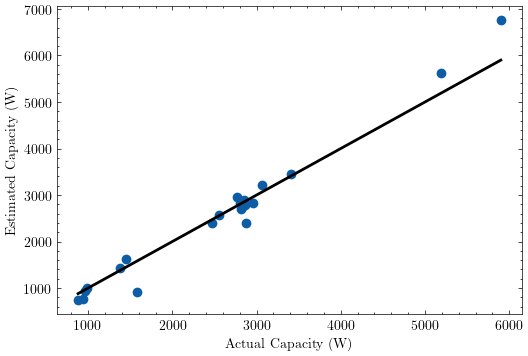

0.9475271825407134

In [19]:
# plot the estimated capacity vs the actual capacity
# the second column of df_pv_capacity is the actual capacity
plot_actual_vs_predicted(df_pv_capacity.iloc[:, 1], capacity_based_load,xlabel='Actual Capacity (W)',ylabel='Estimated Capacity (W)',trendline=False)
# calculate the R2 score
calc_r2_score(df_pv_capacity.iloc[:, 1], capacity_based_load)

Except 2108P and 3307S, the capacity of other households are well estimated.\
TODO: check what is wrong with these two.

In [20]:
# print the real capacity and estimated of each household together
for i in range(len(df_pv_capacity)):
    print(f'The real capacity of {df_pv_capacity.iloc[i, 0]} is {df_pv_capacity.iloc[i, 1]} W, and the estimated capacity is {capacity_based_load[i]} W')

The real capacity of 1011W is 2963.038537148181 W, and the estimated capacity is 2823.161754987146 W
The real capacity of 1954W is 2819.0921551825563 W, and the estimated capacity is 2689.799409676182 W
The real capacity of 1955A is 2825.082005695712 W, and the estimated capacity is 2736.57976623251 W
The real capacity of 1964J is 2770.8490332956994 W, and the estimated capacity is 2966.476239396331 W
The real capacity of 2053G is 3409.944231715041 W, and the estimated capacity is 3447.785025716503 W
The real capacity of 2442E is 1446.0585398352928 W, and the estimated capacity is 1619.973332521247 W
The real capacity of 3070L is 2465.613341818588 W, and the estimated capacity is 2398.4416180854932 W
The real capacity of 3517V is 879.8075244566814 W, and the estimated capacity is 732.9235265793908 W
The real capacity of 3660D is 2857.5149109892063 W, and the estimated capacity is 2786.20387358951 W
The real capacity of 3726A is 3065.9703533065262 W, and the estimated capacity is 3218.8

/tmp/ipykernel_42346/4247410128.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'The real capacity of {df_pv_capacity.iloc[i, 0]} is {df_pv_capacity.iloc[i, 1]} W, and the estimated capacity is {capacity_based_load[i]} W')


In [21]:
# sum up the capacity of all households both real and estimated
real_capacity = df_pv_capacity['capacity'].sum()
estimated_capacity = capacity_based_load.sum()
print(f'The real capacity is {real_capacity} W, and the estimated capacity is {estimated_capacity} W')
# print the error rate
capacity_error_rate = (real_capacity - estimated_capacity) / real_capacity * 100
print(f'The error rate is {capacity_error_rate}%')
error_factor= real_capacity/estimated_capacity
print(f'The error factor is {error_factor}')

The real capacity is 53504.32336904934 W, and the estimated capacity is 53531.99867354572 W
The error rate is -0.051725361155368625%
The error factor is 0.9994830138014247


In [22]:
# save the error rate to a npy file
np.save("../data/nl/capacity_error_rate.npy", capacity_error_rate)
# save the error factor to a npy file
np.save("../data/nl/capacity_error_factor.npy", error_factor)

## Sensitivity analysis

In [23]:
# test the irradiance_threshold_noon( ranging 100 to 800,step 100) and irradiance_threshold_night(ranging [0.01,0.1,1,10,50])
def sensitivity_analysis_irradiance_threshold(df_tmp,real_capacity_tmp,fig_name,base_load_correction_factor=None,metric='PE'):
    list_irradiance_thresholds_noon = [10, 20, 30, 40] + list(range(50, 550, 50))
    list_irradiance_thresholds_night = [0.01, 0.1, 1, 10]
    net_cols_without_total_net = [col for col in df_tmp.columns if col.endswith('_net') and col != 'total_net']
    # store the error rates in a matrix
    error_rates = np.zeros((len(list_irradiance_thresholds_noon), len(list_irradiance_thresholds_night)))
    for i, irradiance_threshold_noon in enumerate(list_irradiance_thresholds_noon):
        for j, irradiance_threshold_night in enumerate(list_irradiance_thresholds_night):
            cap_est_based_load = capacity_estimation_based_load(df_tmp,net_cols_without_total_net,irradiance_threshold_noon,irradiance_threshold_night,base_load_correction_factor=base_load_correction_factor)
            capacity_based_load = cap_est_based_load.estimate_capacity()
            if metric == 'PE':
                error_rates[i, j] = calc_percentage_error(real_capacity_tmp,capacity_based_load)
            elif metric == 'MPE':
                error_rates[i, j] = calc_mean_percentage_error(real_capacity_tmp,capacity_based_load)
            elif metric == 'R2':
                error_rates[i, j] = calc_r2_score(real_capacity_tmp,capacity_based_load)
    # put error_rates, 0, and error_rates.max() in a ascending order list
    v_min_c_max = sorted([error_rates.min(), 0, error_rates.max()])
    if metric == 'R2':
        ticks=np.linspace(-1, 1, 11)
        v_min_n_max=[-1, 1]
        cmap='rocket'
        label='$\mathrm{R}^2$'
    if metric == 'PE':
        ticks=np.linspace(-100, 100, 11)
        v_min_n_max=[-100, 100]
        cmap='RdBu_r'
        label='Percentage Error ($\%$)'
    if metric == 'MPE':
        ticks=np.linspace(-100, 100, 11)
        v_min_n_max=[-100, 100]
        cmap='RdBu_r'
        label='Mean Percentage Error ($\%$)'
    # Plot heatmap
    plt.style.use(['science'])
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        error_rates,
        cmap=cmap,
        center=0,
        linewidths=0.1,
        vmin=v_min_n_max[0],
        vmax=v_min_n_max[1],
        xticklabels=list_irradiance_thresholds_night,
        yticklabels=list_irradiance_thresholds_noon,
        annot=True,
        cbar_kws={
            'label': label,
            'ticks': ticks  
        }
    )
    # Configure axis labels
    plt.xlabel('$I_{night}$ (W/m$^2$)')
    plt.ylabel('$I_{day}$ (W/m$^2$)')
    # Rotate y-axis labels to horizontal
    plt.yticks(rotation=0)
    
    # Save and display
    plt.tight_layout()
    plt.savefig(fig_name, format='pdf')
    plt.show()
    return None

# base_load_correction_factor for two parts

In [24]:
# columns that ends with '_net'
net_cols = [col for col in df_part1.columns if col.endswith('_net')]
# create an instance of capacity_estimation_based_load
# remove total_net and households to remove from net_cols
net_cols_part1 = [col for col in net_cols if col != 'total_net' and col not in households_to_remove_with_suffix]
net_cols_without_total_net_part1 = [col for col in net_cols_part1 if col != 'total_net']
cap_est_based_load_part1_tmp = capacity_estimation_based_load(df_part1,net_cols_without_total_net_part1)
cap_est_based_load_part1_tmp.estimate_capacity()
base_load_correction_factor_from_part1=cap_est_based_load_part1_tmp.base_load_correction_factor

In [25]:
# columns that ends with '_net'
net_cols = [col for col in df_part2.columns if col.endswith('_net')]
# create an instance of capacity_estimation_based_load
# remove total_net and households to remove from net_cols
net_cols_part2 = [col for col in net_cols if col != 'total_net' and col not in households_to_remove_with_suffix]
net_cols_without_total_net_part2 = [col for col in net_cols_part2 if col != 'total_net']
cap_est_based_load_part2_tmp = capacity_estimation_based_load(df_part2,net_cols_without_total_net_part2)
cap_est_based_load_part2_tmp.estimate_capacity()
base_load_correction_factor_from_part2=cap_est_based_load_part2_tmp.base_load_correction_factor

In [26]:
print(f'base_load_correction_factor_from_part2: {base_load_correction_factor_from_part2}')

base_load_correction_factor_from_part2: 1.0233585991896819


# Estimation for part 1

In [27]:
# columns that ends with '_net'
net_cols = [col for col in df_part1.columns if col.endswith('_net')]
# create an instance of capacity_estimation_based_load
# remove total_net and households to remove from net_cols
net_cols_part1 = [col for col in net_cols if col != 'total_net' and col not in households_to_remove_with_suffix]
net_cols_without_total_net = [col for col in net_cols_part1 if col != 'total_net']

cap_est_based_load_part1 = capacity_estimation_based_load(df_part1,net_cols_without_total_net,base_load_correction_factor=base_load_correction_factor_from_part2)
# cap_est_based_load_part1 = capacity_estimation_based_load(df_part1,net_cols_without_total_net,base_load_correction_factor=1)
capacity_based_load_part1 = cap_est_based_load_part1.estimate_capacity()
capacity_based_load_part1

1011W_net    2832.826926
1954W_net    2702.341762
1955A_net    2747.832491
1964J_net    2986.575649
2053G_net    3461.853901
2442E_net    1636.837883
3070L_net    2407.952255
3517V_net     743.028715
3660D_net    2796.097767
3726A_net    3231.682075
dtype: float64

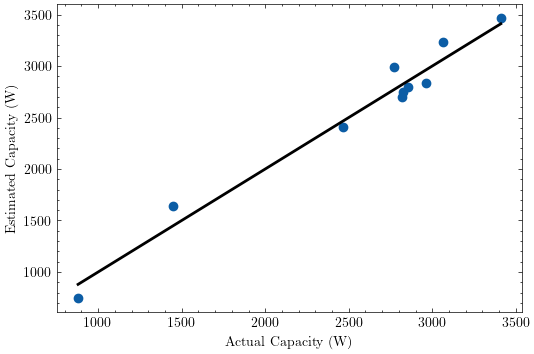

0.968002003553638

In [28]:
# plot the estimated capacity vs the actual capacity
# the second column of df_pv_capacity is the actual capacity
# TODO: add the name of the households to the figure, so each dot has a label
plot_actual_vs_predicted(df_pv_capacity_part1.iloc[:, 1], capacity_based_load_part1,fig_name='../figs/actual_vs_predicted_capacity_part1.pdf',xlabel='Actual Capacity (W)',ylabel='Estimated Capacity (W)',trendline=False)
# calculate the R2 score
calc_r2_score(df_pv_capacity_part1.iloc[:, 1], capacity_based_load_part1)

In [29]:
# print the real capacity and estimated of each household together
for i in range(len(df_pv_capacity_part1)):
    print(f'The real capacity of {df_pv_capacity_part1.iloc[i, 0]} is {df_pv_capacity_part1.iloc[i, 1]} W, and the estimated capacity is {capacity_based_load_part1[i]} W')

The real capacity of 1011W is 2963.038537148181 W, and the estimated capacity is 2832.8269256381905 W
The real capacity of 1954W is 2819.0921551825563 W, and the estimated capacity is 2702.3417617248983 W
The real capacity of 1955A is 2825.082005695712 W, and the estimated capacity is 2747.8324912523017 W
The real capacity of 1964J is 2770.8490332956994 W, and the estimated capacity is 2986.575649304446 W
The real capacity of 2053G is 3409.944231715041 W, and the estimated capacity is 3461.853900919736 W
The real capacity of 2442E is 1446.0585398352928 W, and the estimated capacity is 1636.8378829493208 W
The real capacity of 3070L is 2465.613341818588 W, and the estimated capacity is 2407.9522554376726 W
The real capacity of 3517V is 879.8075244566814 W, and the estimated capacity is 743.0287146711897 W
The real capacity of 3660D is 2857.5149109892063 W, and the estimated capacity is 2796.097767120508 W
The real capacity of 3726A is 3065.9703533065262 W, and the estimated capacity is 

/tmp/ipykernel_42346/2473863109.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'The real capacity of {df_pv_capacity_part1.iloc[i, 0]} is {df_pv_capacity_part1.iloc[i, 1]} W, and the estimated capacity is {capacity_based_load_part1[i]} W')


https://en.wikipedia.org/wiki/Mean_percentage_error

In [30]:
# sum up the capacity of all households both real and estimated
real_capacity_part1 = df_pv_capacity_part1['capacity'].to_numpy()
estimated_capacity_part1 = capacity_based_load_part1.to_numpy()
real_capacity_part1_sum = df_pv_capacity_part1['capacity'].sum()
estimated_capacity_part1_sum = capacity_based_load_part1.sum()
print(f'The real capacity is {real_capacity_part1_sum} W, and the estimated capacity is {estimated_capacity_part1_sum} W')
PE_part1=calc_percentage_error(real_capacity_part1,estimated_capacity_part1)
print(f'The percentage error is {PE_part1}%')
MPE_part1=calc_mean_percentage_error(real_capacity_part1,estimated_capacity_part1)
print(f'The mean percentage error is {MPE_part1}%')
R2_part1=calc_r2_score(real_capacity_part1,estimated_capacity_part1)
print(f'The R2 score is {R2_part1}')
error_factor_part1= calc_error_factor(real_capacity_part1_sum,estimated_capacity_part1_sum)
print(f'The error factor is {error_factor_part1}')

The real capacity is 25502.97063344348 W, and the estimated capacity is 25547.02942390774 W
The percentage error is -0.17275944476241928%
The mean percentage error is 0.33989328530910273%
The R2 score is 0.968002003553638
The error factor is 0.9982753849876953


In [31]:
# save the error rate to a npy file
np.save("../data/nl/capacity_error_rate_part1.npy", PE_part1)
# save the error factor to a npy file
np.save("../data/nl/capacity_error_factor_part1.npy", error_factor_part1)

## SA for part 1

In [32]:
df_part1_cleaned=df_part1.drop(columns=['1955A_pv','1955A_net'])

In [33]:
# 3 levels of availability, 1 month (2018-06), 3 months(2018-06-2018-08), and 6 months(2018-06-2018-11)
df_part1_1month_summer = df_part1_cleaned[(df_part1_cleaned['datetime'] >= '2018-06-01') & (df_part1_cleaned['datetime'] <= '2018-06-30')]
df_part1_1month_winter = df_part1_cleaned[(df_part1_cleaned['datetime'] >= '2018-12-01') & (df_part1_cleaned['datetime'] <= '2018-12-31')]
df_part1_3months = df_part1_cleaned[(df_part1_cleaned['datetime'] >= '2018-06-01') & (df_part1_cleaned['datetime'] <= '2018-08-31')]
df_part1_6months = df_part1_cleaned[(df_part1_cleaned['datetime'] >= '2018-06-01') & (df_part1_cleaned['datetime'] <= '2018-11-30')]

In [34]:
df_pv_capacity_part1_cleaned = df_pv_capacity_part1[df_pv_capacity_part1['household'] != '1955A']

In [35]:
real_capacity_part1_cleaned = df_pv_capacity_part1_cleaned['capacity'].to_numpy()

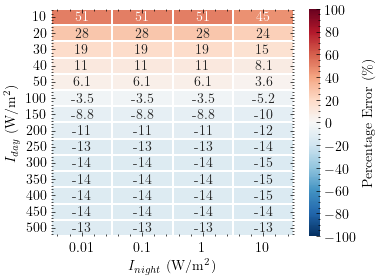

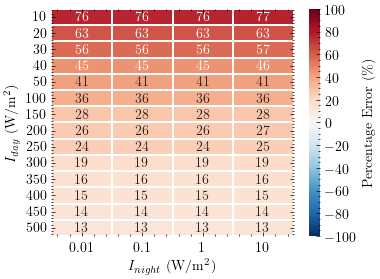

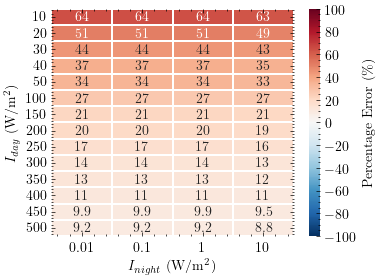

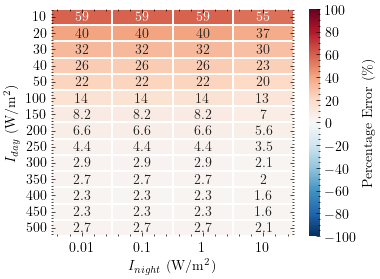

In [36]:
sensitivity_analysis_irradiance_threshold(df_part1,real_capacity_part1_cleaned,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1.pdf',base_load_correction_factor=base_load_correction_factor_from_part2)
sensitivity_analysis_irradiance_threshold(df_part1_1month_summer,real_capacity_part1_cleaned,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1_1month_summer_PE.pdf',base_load_correction_factor=base_load_correction_factor_from_part2,metric='PE')
# sensitivity_analysis_irradiance_threshold(df_part1_1month_winter,real_capacity_part1_cleaned,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1_1month_winter_PE.pdf',base_load_correction_factor=base_load_correction_factor_from_part2,metric='PE')
sensitivity_analysis_irradiance_threshold(df_part1_3months,real_capacity_part1_cleaned,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1_3months_PE.pdf',base_load_correction_factor=base_load_correction_factor_from_part2,metric='PE')
sensitivity_analysis_irradiance_threshold(df_part1_6months,real_capacity_part1_cleaned,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1_6months_PE.pdf',base_load_correction_factor=base_load_correction_factor_from_part2,metric='PE')

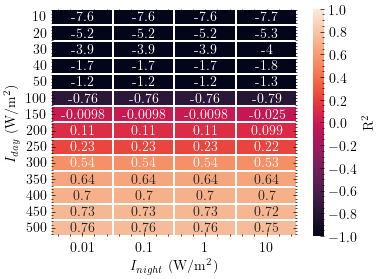

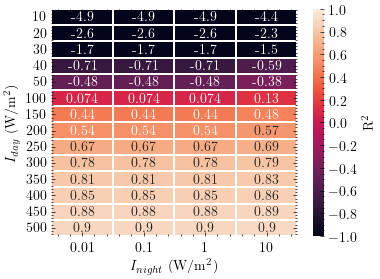

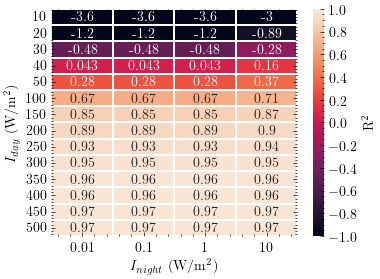

In [37]:
sensitivity_analysis_irradiance_threshold(df_part1_1month_summer,real_capacity_part1_cleaned,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1_1month_summer_r2.pdf',base_load_correction_factor=base_load_correction_factor_from_part2,metric='R2')
# sensitivity_analysis_irradiance_threshold(df_part1_1month_winter,real_capacity_part1_cleaned,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1_1month_winter_r2.pdf',base_load_correction_factor=base_load_correction_factor_from_part2,metric='R2')
sensitivity_analysis_irradiance_threshold(df_part1_3months,real_capacity_part1_cleaned,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1_3months_r2.pdf',base_load_correction_factor=base_load_correction_factor_from_part2,metric='R2')
sensitivity_analysis_irradiance_threshold(df_part1_6months,real_capacity_part1_cleaned,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1_6months_r2.pdf',base_load_correction_factor=base_load_correction_factor_from_part2,metric='R2')

# Estimation for part 2

In [38]:
# columns that ends with '_net'
net_cols = [col for col in df_part2.columns if col.endswith('_net')]
# create an instance of capacity_estimation_based_load
# remove total_net and households to remove from net_cols
net_cols_part2 = [col for col in net_cols if col != 'total_net' and col not in households_to_remove_with_suffix]
net_cols_without_total_net = [col for col in net_cols_part2 if col != 'total_net']

cap_est_based_load_part2 = capacity_estimation_based_load(df_part2,net_cols_without_total_net,base_load_correction_factor=base_load_correction_factor_from_part1)
# cap_est_based_load_part2 = capacity_estimation_based_load(df_part2,net_cols_without_total_net,base_load_correction_factor=1)
capacity_based_load_part2 = cap_est_based_load_part2.estimate_capacity()
capacity_based_load_part2

3932W_net    1000.017630
4451M_net    5567.843758
5427W_net    1416.096083
5815T_net    2861.991587
7426U_net     738.223242
7679U_net    2387.658439
7710F_net     877.040866
8319Q_net    2808.088266
9248C_net     927.158542
9370J_net    2562.952176
9991J_net    6687.379462
dtype: float64

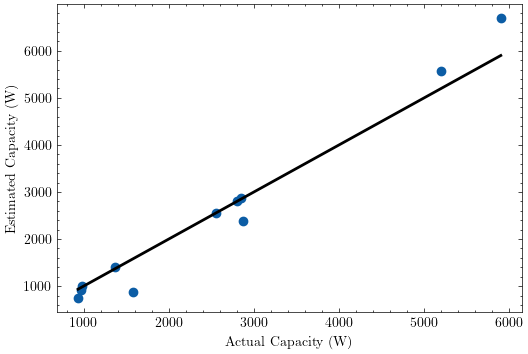

0.946302383659857

In [39]:
# plot the estimated capacity vs the actual capacity
# the second column of df_pv_capacity is the actual capacity
# TODO: add the name of the households to the figure, so each dot has a label
plot_actual_vs_predicted(df_pv_capacity_part2.iloc[:, 1], capacity_based_load_part2,fig_name='../figs/actual_vs_predicted_capacity_part2.pdf',xlabel='Actual Capacity (W)',ylabel='Estimated Capacity (W)',trendline=False)
# calculate the R2 score
calc_r2_score(df_pv_capacity_part2.iloc[:, 1], capacity_based_load_part2)

In [40]:
# print the real capacity and estimated of each household together
for i in range(len(df_pv_capacity_part2)):
    print(f'The real capacity of {df_pv_capacity_part2.iloc[i, 0]} is {df_pv_capacity_part2.iloc[i, 1]} W, and the estimated capacity is {capacity_based_load_part2[i]} W')

The real capacity of 3932W is 981.1300646774204 W, and the estimated capacity is 1000.0176304804306 W
The real capacity of 4451M is 5192.548449412307 W, and the estimated capacity is 5567.843758453644 W
The real capacity of 5427W is 1374.0352311787085 W, and the estimated capacity is 1416.0960833728725 W
The real capacity of 5815T is 2848.621676525069 W, and the estimated capacity is 2861.9915871222966 W
The real capacity of 7426U is 934.9368539705436 W, and the estimated capacity is 738.2232415548674 W
The real capacity of 7679U is 2871.8978370916 W, and the estimated capacity is 2387.6584389272803 W
The real capacity of 7710F is 1574.4987158879314 W, and the estimated capacity is 877.0408662689392 W
The real capacity of 8319Q is 2803.4673875296758 W, and the estimated capacity is 2808.088265911996 W
The real capacity of 9248C is 965.2160832358916 W, and the estimated capacity is 927.1585423315493 W
The real capacity of 9370J is 2554.7716128546763 W, and the estimated capacity is 2562

/tmp/ipykernel_42346/949596013.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'The real capacity of {df_pv_capacity_part2.iloc[i, 0]} is {df_pv_capacity_part2.iloc[i, 1]} W, and the estimated capacity is {capacity_based_load_part2[i]} W')


In [41]:
# sum up the capacity of all households both real and estimated
real_capacity_part2 = df_pv_capacity_part2['capacity'].sum()
estimated_capacity_part2 = capacity_based_load_part2.sum()
print(f'The real capacity is {real_capacity_part2} W, and the estimated capacity is {estimated_capacity_part2} W')
# print the error rate
capacity_error_rate_part2 = (real_capacity_part2 - estimated_capacity_part2) / real_capacity_part2 * 100
print(f'The error rate is {capacity_error_rate_part2}%')
error_factor_part2= real_capacity_part2/estimated_capacity_part2
print(f'The error factor is {error_factor_part2}')

The real capacity is 28001.352735605855 W, and the estimated capacity is 27834.45005268077 W
The error rate is 0.5960522139805549%
The error factor is 1.0059962629981622


In [42]:
# save the error rate to a npy file
np.save("../data/nl/capacity_error_rate_part2.npy", capacity_error_rate_part2)
# save the error factor to a npy file
np.save("../data/nl/capacity_error_factor_part2.npy", error_factor_part2)

## SA for part 2

In [43]:
real_capacity_part2= df_pv_capacity_part2['capacity'].to_numpy()

In [44]:
df_part2_1month_summer = df_part2[(df_part2['datetime'] >= '2018-06-01') & (df_part2['datetime'] <= '2018-06-30')]
df_part2_1month_winter = df_part2[(df_part2['datetime'] >= '2018-12-01') & (df_part2['datetime'] <= '2018-12-31')]
df_part2_3months = df_part2[(df_part2['datetime'] >= '2018-06-01') & (df_part2['datetime'] <= '2018-08-31')]
df_part2_6months = df_part2[(df_part2['datetime'] >= '2018-06-01') & (df_part2['datetime'] <= '2018-11-30')]

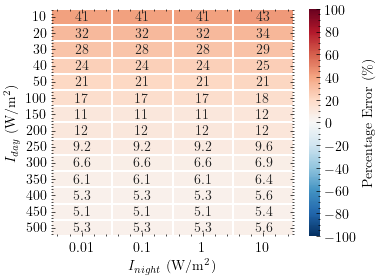

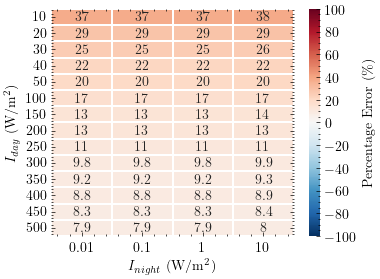

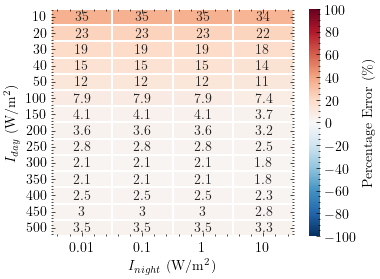

In [45]:
sensitivity_analysis_irradiance_threshold(df_part2_1month_summer,real_capacity_part2,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2_1month_summer_PE.pdf',base_load_correction_factor=base_load_correction_factor_from_part1,metric='PE')
# sensitivity_analysis_irradiance_threshold(df_part2_1month_winter,real_capacity_part2,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2_1month_winter_PE.pdf',base_load_correction_factor=base_load_correction_factor_from_part1,metric='PE')
sensitivity_analysis_irradiance_threshold(df_part2_3months,real_capacity_part2,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2_3months_PE.pdf',base_load_correction_factor=base_load_correction_factor_from_part1,metric='PE')
sensitivity_analysis_irradiance_threshold(df_part2_6months,real_capacity_part2,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2_6months_PE.pdf',base_load_correction_factor=base_load_correction_factor_from_part1,metric='PE')

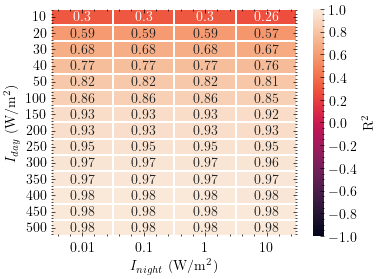

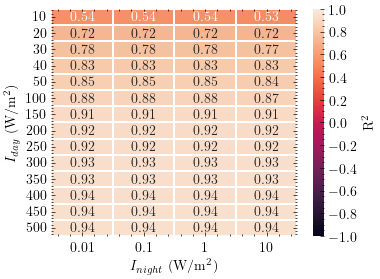

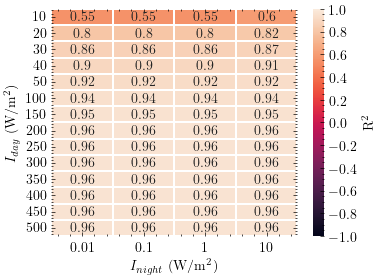

In [46]:
sensitivity_analysis_irradiance_threshold(df_part2_1month_summer,real_capacity_part2,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2_1month_summer_r2.pdf',base_load_correction_factor=base_load_correction_factor_from_part1,metric='R2')
# sensitivity_analysis_irradiance_threshold(df_part2_1month_winter,real_capacity_part2,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2_1month_winter_r2.pdf',base_load_correction_factor=base_load_correction_factor_from_part1,metric='R2')
sensitivity_analysis_irradiance_threshold(df_part2_3months,real_capacity_part2,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2_3months_r2.pdf',base_load_correction_factor=base_load_correction_factor_from_part1,metric='R2')
sensitivity_analysis_irradiance_threshold(df_part2_6months,real_capacity_part2,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2_6months_r2.pdf',base_load_correction_factor=base_load_correction_factor_from_part1,metric='R2')